###Mounting drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Libraries

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torchvision
import cv2
import csv
from skimage import io
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision import transforms as T
from skimage import io
from torchvision import ops
import torch.nn.functional as F

##Preprocessing

###Unzip dataset (one time)

In [3]:
!unzip drive/MyDrive/Progetto_vision/archive.zip -d drive/MyDrive/Progetto_vision/

Output streaming troncato alle ultime 5000 righe.
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2910).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2911).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2912).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2913).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2914).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2915).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2916).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2917).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2918).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2919).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (292).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2920).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2921).jpg  
  inflating: drive/MyDrive/Progetto_vision/Humans/1 (2922).jpg  
  inflating: drive/MyDrive/Progetto_visio

###Variables

In [4]:
DATASET_PATH = 'drive/MyDrive/Progetto_vision/Humans/'
CASCADE_PATH='drive/MyDrive/Progetto_vision/haar-face-detection/haarcascade_frontalface_default.xml'
DETECTED_PATH='drive/MyDrive/Progetto_vision/Detected_faces/'
CSV_PATH='drive/MyDrive/Progetto_vision/train.csv'

WIDTH_RESIZE=256 #modifica poi in base al modello
HEIGHT_RESIZE=160 #modifica poi in base al modello

###Dataframe

In [5]:
#every element in df contains the path of an image
df = [os.path.join(DATASET_PATH,x) for x in os.listdir(DATASET_PATH)]
print('Total Images:', len(df))

Total Images: 7219


###Resizing images (one time)

In [6]:
#resizing images (se da errore su un'immagine significa che è corrotta, quindi è da eliminare dal dataset)
for path in df:
  image = Image.open(path)
  img_rgb=image.convert('RGB')
  img_rsz = img_rgb.resize((WIDTH_RESIZE,HEIGHT_RESIZE))
  img_rsz.save(path)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


###Check images

drive/MyDrive/Progetto_vision/Humans/1 (5230).jpg
Image Size (160, 256, 3)
Showing Image number 4849


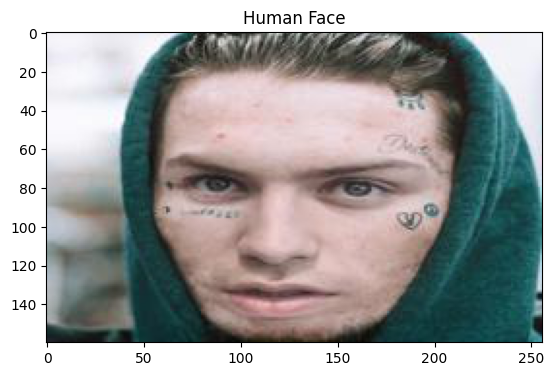

In [7]:
#showing a random image in the dataset
rnd=random.randint(0,len(df))
img= Image.open(df[rnd])
print(df[rnd])
print('Image Size',np.asarray(img).shape)
print('Showing Image number',rnd)

plt.imshow(img)
plt.title('Human Face')
plt.show()

###Requirements

In [ ]:
!pip install opencv-python

In [ ]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/haar-face-detection/haar-face-detection.zip
!unzip -qq haar-face-detection.zip

###Building csv and testset (one time)

The column of the csv are related to: Filename, x1, y1, x2, y2.
Where (x1,y1) and (x2,y2) are the two extreme of the rectangle.

In [8]:
face_cascade = cv2.CascadeClassifier(CASCADE_PATH)
i=0
with open(CSV_PATH,'a+',newline='') as write_obj:
    writer=csv.writer(write_obj)
    writer.writerow(['name','xmin','ymin','xmax','ymax'])
for path in df:
  img= cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_cascade.detectMultiScale(gray, 1.2, 4)

  #selecting only images with one face
  if len(faces)==1:
    #setting up new names of the images
    new_name_dataset=DATASET_PATH+f'face{i}.jpg'
    new_name_detected=DETECTED_PATH+f'face{i}.jpg'
    os.rename(path,new_name_dataset)
    for (x, y, w, h) in faces:
      #building rectangle
      cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 1)
      #saving image with bounding box
      cv2.imwrite(new_name_detected,img)
      #saving parameters in a csv file
      with open(CSV_PATH,'a+',newline='') as write_obj:
        writer=csv.writer(write_obj)
        writer.writerow([f'face{i}.jpg',x,y,x+w,y+h])
    i=i+1
  else:
    #removing images where no faces has been detected
    os.remove(path)

cv2.waitKey()


-1

###New dataframes

In [9]:
#new dataframe of dataset
new_df = [os.path.join(DATASET_PATH,x) for x in os.listdir(DATASET_PATH)]
print('Final total images:', len(new_df))

#new dataframe of detected faces
#new_df_detected = [os.path.join(DETECTED_PATH,x) for x in os.listdir(DETECTED_PATH)]
#print('Final total images detected:', len(new_df_detected))

def create_df():
  name=[]
  idx=[]
  for dirname,_,filenames in os.walk(DETECTED_PATH):
    for filename in filenames:
      nameface=filename.split('.')[0]
      name.append(nameface)
      idx.append(nameface.split('e')[1])
  return pd.DataFrame({'id':name})

new_df_detected= create_df()
print('Final total images detected:', len(new_df_detected))


Final total images: 2282
Final total images detected: 2282


In [ ]:
new_df_detected

,id
0,face3049
1,face3050
2,face3051
3,face3052
4,face3053
...,...
4044,face44
4045,face45
4046,face46
4047,face47


Image Size (160, 256, 3)
Showing Image number 245


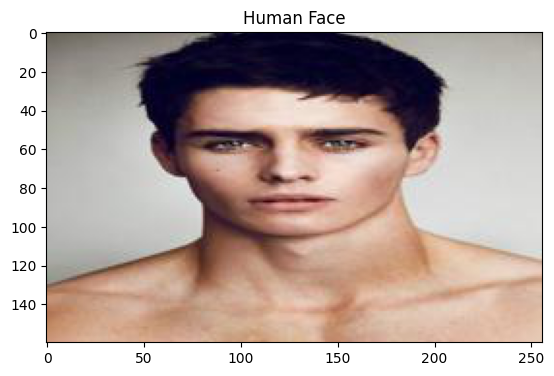

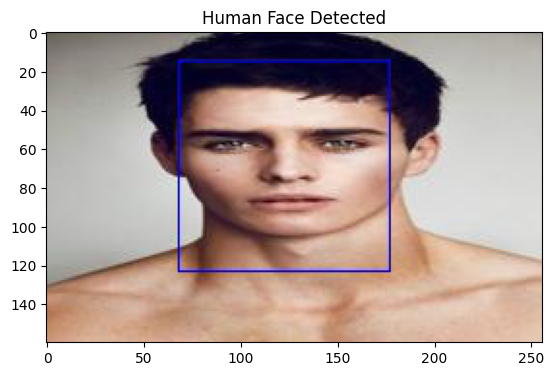

In [10]:
rnd=random.randint(0,len(new_df)-1)
img= Image.open(new_df[rnd])
img2=Image.open(DETECTED_PATH + new_df_detected['id'][rnd] +'.jpg')
print('Image Size',np.asarray(img).shape)
print('Showing Image number',rnd)

plt.imshow(img)
plt.title('Human Face')
plt.show()

plt.imshow(img2)
plt.title('Human Face Detected')
plt.show()

##Dataset

In [11]:
X_trainval, X_test = train_test_split(new_df_detected['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  1745
Val Size     :  308
Test Size    :  229


In [71]:
class FaceDetectionDataset(Dataset):
  def __init__(self,img_path,bboxes_path,X, transform=None):
    self.img_path=img_path
    self.bboxes_path=pd.read_csv(bboxes_path)
    self.X = X
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):

    img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    bbox = self.bboxes_path.loc[int(self.X[idx].split('e')[1])]
    x1,y1,x2,y2 = bbox['xmin'],bbox['ymin'],bbox['xmax'],bbox['ymax']

    boxes = [x1,y1,x2,y2]
    boxes = np.array(boxes)
    boxes= torch.as_tensor(boxes, dtype=torch.float32)

    if self.transform is None:
      img = Image.fromarray(img)

    t = T.ToTensor()
    img = t(img)



    return img,boxes


 TEST

In [13]:
prova= pd.read_csv(CSV_PATH)
prova.loc[2]


name    face2.jpg
xmin           91
ymin            9
xmax          202
ymax          120
Name: 2, dtype: object

In [14]:
fd_train= FaceDetectionDataset(DETECTED_PATH,CSV_PATH,X_train,None)
fd_val= FaceDetectionDataset(DETECTED_PATH,CSV_PATH,X_val,None)

In [15]:
batch_size=8

train_dataloader= DataLoader(fd_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(fd_val,batch_size=batch_size, shuffle=True)


In [16]:
for img_batch,bbox_batch in train_dataloader:
  img_data_all=img_batch
  gt_bboxes_all = bbox_batch
  break
gt_bboxes_all = gt_bboxes_all[:2]
img_data_all= img_data_all[:2]

##Network

###Model

Per il training usare il dataset con i bounding box (Detected_faces)

In [27]:
import torch.nn as nn
model= torchvision.models.resnet50(pretrained=True)
req_layers= list(model.children())[:6]
backbone=nn.Sequential(*req_layers)

In [28]:
for parameter in backbone.named_parameters():
  parameter[1].requires_grad=True

In [29]:
out = backbone(img_data_all)

In [30]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [31]:
out_c, out_h, out_w

(512, 20, 32)

In [32]:
width_scale_factor = WIDTH_RESIZE //out_w
height_scale_factor = HEIGHT_RESIZE //out_h
width_scale_factor,height_scale_factor

(8, 8)

In [33]:
def display_img(filters_data, fig, axes):
    for i, data in enumerate(filters_data):
        if isinstance(data, torch.Tensor):
            data = data.permute(1,2,0)

       # Seleziona l'ordine corretto degli assi

        axes[i].imshow(data)
        axes[i].axis('on')

    return fig, axes

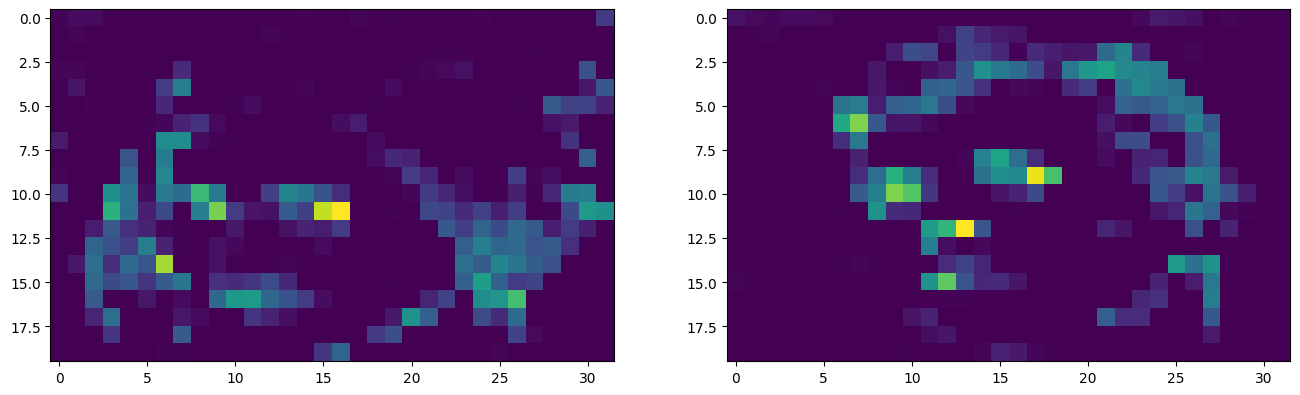

In [34]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

### Anchor points

## Util Functions

In [35]:
def gen_anc_centers(out_size):
    out_h, out_w = out_size

    anc_pts_x = torch.arange(0, out_w) + 0.5
    anc_pts_y = torch.arange(0, out_h) + 0.5

    return anc_pts_x, anc_pts_y


In [36]:
def display_grid(x_coords, y_coords, figure, axis):
  for x in x_coords.numpy():
    for y in y_coords.numpy():
      axis.scatter(x, y, color='white', marker='+')

  return figure, axis

In [37]:
def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    n_anc_boxes = len(anc_scales) * len(anc_ratios)
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0) \
                              , anc_pts_y.size(dim=0), n_anc_boxes, 4) # shape - [1, Hmap, Wmap, n_anchor_boxes, 4]

    for ix, xc in enumerate(anc_pts_x):
        for jx, yc in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale

                    xmin = xc - w / 2
                    ymin = yc - h / 2
                    xmax = xc + w / 2
                    ymax = yc + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=out_size)

    return anc_base

In [38]:
def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']

    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes

    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor
    else:
        # pixel image to activation map
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor

    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)

    return proj_bboxes

In [39]:
def display_bbox(bbox, fig, ax):
    for elem in bbox:
      x1, y1, x2, y2 = elem
      rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
      ax.add_patch(rect)
    # Disegna il rettangolo della bounding box



    return fig, ax

In [40]:
def display_bbox_color(bbox, fig, ax, col):
    for elem in bbox:
      x1, y1, x2, y2 = elem
      rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=col, linewidth=1)
      ax.add_patch(rect)
    # Disegna il rettangolo della bounding box



    return fig, ax

In [41]:
def display_single_bbox(bbox, fig, ax):
    x1, y1, x2, y2 = bbox
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='yellow', linewidth=1)
    ax.add_patch(rect)
    # Disegna il rettangolo della bounding box



    return fig, ax

In [42]:
def display_grid_point(x_coords, y_coords, figure, axis, px_py):


  for x in x_coords.numpy():

    for y in y_coords.numpy():
      if x==px_py[0].numpy() and y==px_py[1].numpy():
        axis.scatter(x, y, color='red', marker='+')
      else:
        axis.scatter(x, y, color='white', marker='+')

  return figure, axis

In [43]:
def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):

    # flatten anchor boxes
    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)

    # get total anchor boxes for a single image
    tot_anc_boxes = anc_boxes_flat.size(dim=1)

    # create a placeholder to compute IoUs amongst the boxes
    ious_mat = torch.zeros((batch_size, tot_anc_boxes,gt_bboxes_all.size(dim=1)))

    # compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        gt_bboxes = torch.unsqueeze(gt_bboxes_all[i], 0)
        anc_boxes = anc_boxes_flat[i]
        #gt_bboxes=torch.cat(gt_bboxes,torch.Tensor([0,0,0,0]))
        ious_mat[i,:] = ops.box_iou(anc_boxes, gt_bboxes)

    return ious_mat

In [44]:
def get_req_anchors(anc_boxes_all, gt_bboxes_all, pos_thresh=0.7, neg_thresh=0.2):

    # get the size and shape parameters
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape

    N = gt_bboxes_all.shape[1] # max number of groundtruth bboxes in a batch

    # get total number of anchor boxes in a single image
    tot_anc_boxes = A * w_amap * h_amap

    # get the iou matrix which contains iou of every anchor box
    # against all the groundtruth bboxes in an image
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)

    #print(iou_mat)

    # for every groundtruth bbox in an image, find the iou
    # with the anchor box which it overlaps the most
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)
    # get positive anchor boxes

    # condition 1: the anchor box with the max iou for every gt bbox
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0)
    # condition 2: anchor boxes with iou above a threshold with any of the gt bboxes
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh)


    positive_anc_ind_sep = torch.where(positive_anc_mask)[0] # get separate indices in the batch
    # combine all the batches and get the idxs of the +ve anchor boxes
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0]


    # for every anchor box, get the iou and the idx of the
    # gt bbox it overlaps with the most
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)

    # get iou scores of the +ve anchor boxes
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]
    # get gt classes of the +ve anchor boxes

    # expand gt classes to map against every anchor box
    #gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N)
    # for every anchor box, consider only the class of the gt bbox it overlaps with the most
    #GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)
    # combine all the batches and get the mapped classes of the +ve anchor boxes
    #GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    #GT_class_pos = GT_class[positive_anc_ind]


    # get gt bbox coordinates of the +ve anchor boxes

    # expand all the gt bboxes to map against every anchor box
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, 4).expand(B, tot_anc_boxes, 4)
    max_iou_per_anc_ind_reshape=max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1).repeat(1, 1, 4)
    # for every anchor box, consider only the coordinates of the gt bbox it overlaps with the most
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind_reshape)
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=-2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]

    # get coordinates of +ve anc boxes
    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2) # flatten all the anchor boxes
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]
    # calculate gt offsets
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)

    # get -ve anchors

    # condition: select the anchor boxes with max iou less than the threshold
    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    # sample -ve samples to match the +ve samples
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]

    return positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, \
         positive_anc_coords, negative_anc_coords, positive_anc_ind_sep

In [45]:
def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1)

In [46]:

def generate_proposals(anchors, offsets):

    # change format of the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    # apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(anchors)
    proposals_[:,0] = anchors[:,0] + offsets[:,0]*anchors[:,2]
    proposals_[:,1] = anchors[:,1] + offsets[:,1]*anchors[:,3]
    proposals_[:,2] = anchors[:,2] * torch.exp(offsets[:,2])
    proposals_[:,3] = anchors[:,3] * torch.exp(offsets[:,3])

    # change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

## Anchors and BBoxes

In [47]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

In [48]:
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

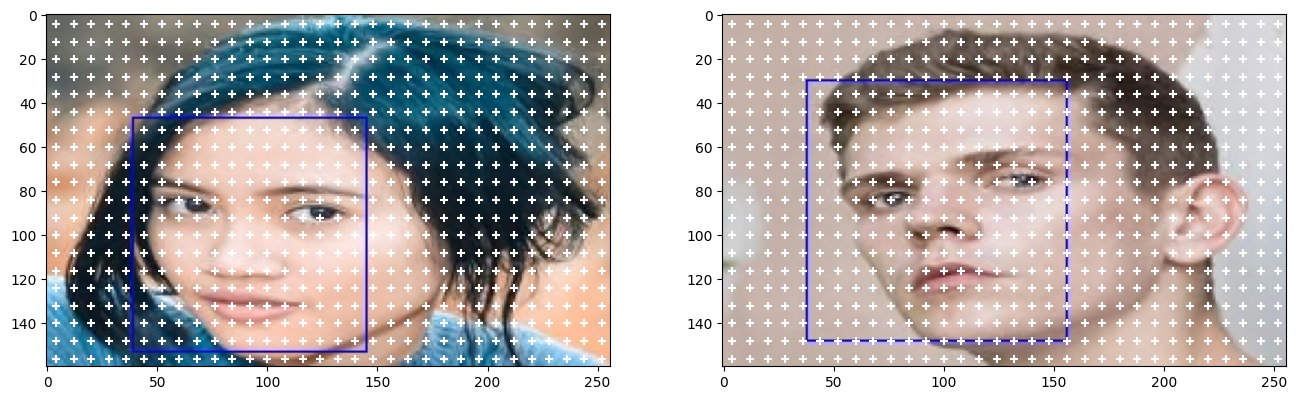

In [49]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

In [50]:
anc_scales = [4, 6, 8]
#anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [51]:
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

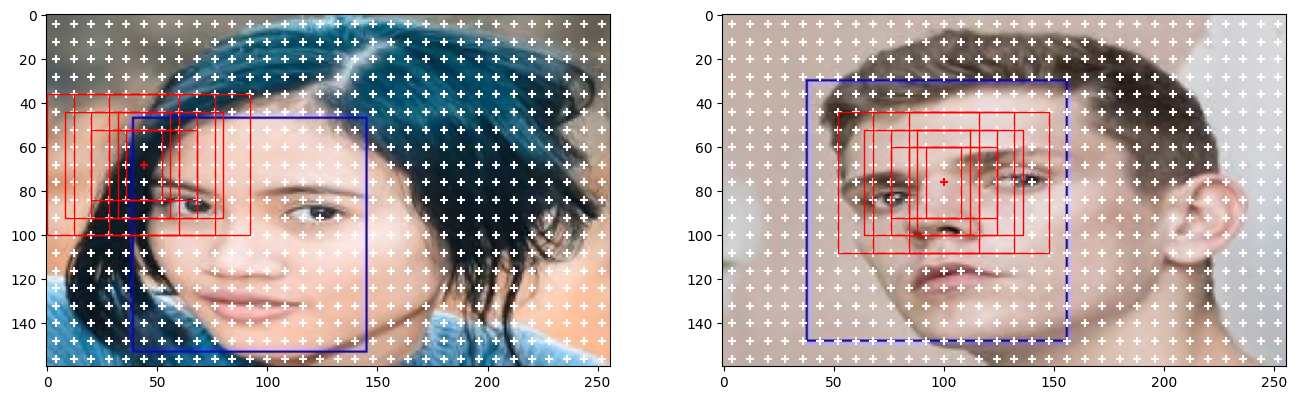

In [52]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all,width_scale_factor , height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]


fig, _ = display_grid_point(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid_point(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

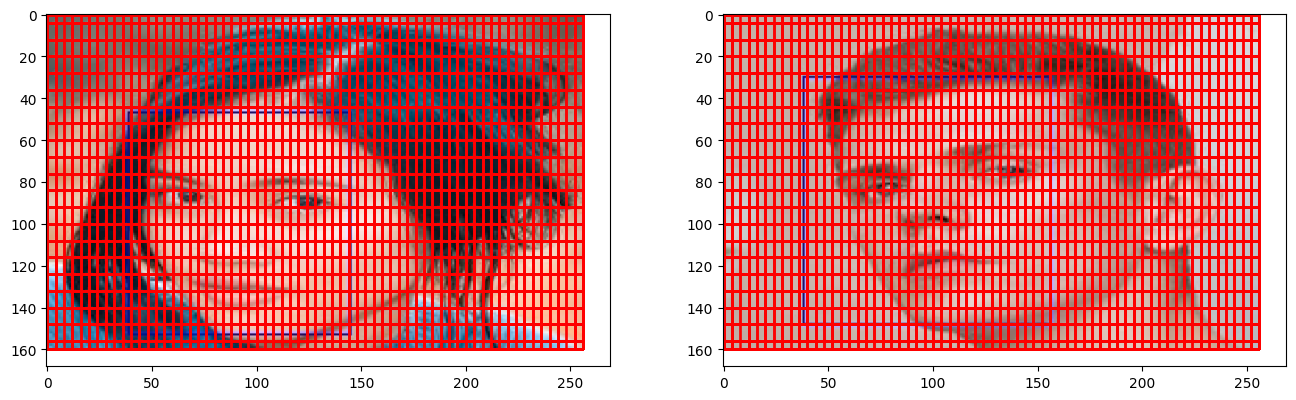

In [53]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0])
        fig, _ = display_bbox(bboxes, fig, axes[1])

In [55]:
pos_thresh = 0.7
neg_thresh = 0.3

gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

In [56]:
gt_bboxes_proj.size()

torch.Size([2, 4])

In [57]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, pos_thresh, neg_thresh)

In [58]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

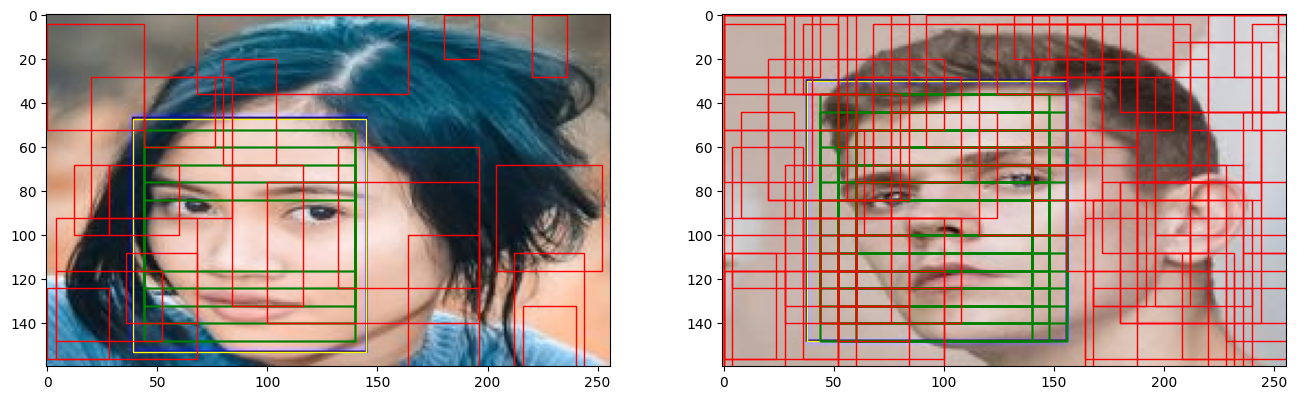

In [59]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_single_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_single_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox_color(pos_anc_1, fig, axes[0], 'green')
fig, _ = display_bbox_color(pos_anc_2, fig, axes[1], 'green')

# plot negative anchor boxes
fig, _ = display_bbox_color(neg_anc_1, fig, axes[0], 'red')
fig, _ = display_bbox_color(neg_anc_2, fig, axes[1], 'red')

##Model

In [60]:
class ProposalModule(nn.Module):
    def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
        super().__init__()
        self.n_anchors = n_anchors
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p_dropout)
        self.conf_head = nn.Conv2d(hidden_dim, n_anchors, kernel_size=1)
        self.reg_head = nn.Conv2d(hidden_dim, n_anchors * 4, kernel_size=1)

    def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
        # determine mode
        if pos_anc_ind is None or neg_anc_ind is None or pos_anc_coords is None:
            mode = 'eval'
        else:
            mode = 'train'

        out = self.conv1(feature_map)
        out = F.relu(self.dropout(out))

        reg_offsets_pred = self.reg_head(out) # (B, A*4, hmap, wmap)
        conf_scores_pred = self.conf_head(out) # (B, A, hmap, wmap)

        if mode == 'train':
            # get conf scores
            conf_scores_pos = conf_scores_pred.flatten()[pos_anc_ind]
            conf_scores_neg = conf_scores_pred.flatten()[neg_anc_ind]
            # get offsets for +ve anchors
            offsets_pos = reg_offsets_pred.contiguous().view(-1, 4)[pos_anc_ind]
            # generate proposals using offsets
            proposals = generate_proposals(pos_anc_coords, offsets_pos)
            return conf_scores_pos, conf_scores_neg, offsets_pos, proposals

        elif mode == 'eval':
            return conf_scores_pred, reg_offsets_pred

In [61]:
def calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size):
    loss_fn = torch.nn.MSELoss(reduction='sum')

    # Calcola la loss dei bounding box utilizzando l'offset ground truth e l'offset predetto
    bbox_loss = loss_fn(offsets_pos, GT_offsets)

    # Normalizza la loss in base alla dimensione del batch
    bbox_loss /= batch_size

    return bbox_loss

In [62]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, out_size, out_channels):
        super().__init__()

        self.img_height, self.img_width = img_size
        self.out_h, self.out_w = out_size

        # downsampling scale factor
        self.width_scale_factor = self.img_width // self.out_w
        self.height_scale_factor = self.img_height // self.out_h

        # scales and ratios for anchor boxes
        self.anc_scales = [4, 6, 8]
        self.anc_ratios = [0.5, 1, 1.5]
        self.n_anc_boxes = len(self.anc_scales) * len(self.anc_ratios)

        # IoU thresholds for +ve and -ve anchors
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3

        # weights for loss
        self.w_reg = 5

        self.proposal_module = ProposalModule(out_channels, n_anchors=self.n_anc_boxes)

    def forward(self, images, gt_bboxes):
        batch_size = images.size(dim=0)
        feature_map = backbone(images) ##rallenta

        # generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
        anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
        # get positive and negative anchors amongst other things
        gt_bboxes_proj = project_bboxes(gt_bboxes, self.width_scale_factor, self.height_scale_factor, mode='p2a')
        positive_anc_ind, negative_anc_ind, GT_conf_scores, \
        GT_offsets, positive_anc_coords, \
        negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj)
        # pass through the proposal module
        conf_scores_pos, conf_scores_neg, offsets_pos, proposals = self.proposal_module(feature_map, positive_anc_ind, \
                                                                                        negative_anc_ind, positive_anc_coords)
        reg_loss = calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size)

        total_rpn_loss = self.w_reg * reg_loss
        return total_rpn_loss, feature_map, proposals, positive_anc_ind_sep

    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        with torch.no_grad():
            batch_size = images.size(dim=0)
            feature_map = backbone(images)

            # generate anchors
            anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
            anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
            anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
            anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)

            # get conf scores and offsets
            conf_scores_pred, offsets_pred = self.proposal_module(feature_map)
            conf_scores_pred = conf_scores_pred.reshape(batch_size, -1)
            offsets_pred = offsets_pred.reshape(batch_size, -1, 4)

            # filter out proposals based on conf threshold and nms threshold for each image
            proposals_final = []
            conf_scores_final = []
            for i in range(batch_size):
                conf_scores = torch.sigmoid(conf_scores_pred[i])
                offsets = offsets_pred[i]
                anc_boxes = anc_boxes_flat[i]
                proposals = generate_proposals(anc_boxes, offsets)
                # filter based on confidence threshold
                conf_idx = torch.where(conf_scores >= conf_thresh)[0]
                conf_scores_pos = conf_scores[conf_idx]
                proposals_pos = proposals[conf_idx]
                # filter based on nms threshold
                nms_idx = ops.nms(proposals_pos, conf_scores_pos, nms_thresh)
                conf_scores_pos = conf_scores_pos[nms_idx]
                proposals_pos = proposals_pos[nms_idx]

                proposals_final.append(proposals_pos)
                conf_scores_final.append(conf_scores_pos)

        return proposals_final, conf_scores_final, feature_map

In [105]:
class FaceDetector(nn.Module):
    def __init__(self, img_size, out_size, out_channels, roi_size):
        super().__init__()
        self.rpn = RegionProposalNetwork(img_size, out_size, out_channels)

    def forward(self, images, gt_bboxes):
        total_rpn_loss, feature_map, proposals, \
        positive_anc_ind_sep = self.rpn(images, gt_bboxes)

        # get separate proposals for each sample
        pos_proposals_list = []
        batch_size = images.size(dim=0)
        for idx in range(batch_size):
            proposal_idxs = torch.where(positive_anc_ind_sep == idx)[0]
            proposals_sep = proposals[proposal_idxs].detach().clone()
            pos_proposals_list.append(proposals_sep)

        total_loss = total_rpn_loss

        return total_loss

    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        batch_size = images.size(dim=0)
        proposals_final, conf_scores_final, feature_map = self.rpn.inference(images, conf_thresh, nms_thresh)

        return proposals_final, conf_scores_final

In [106]:
img_size = (HEIGHT_RESIZE, WIDTH_RESIZE)
out_size = (out_h, out_w)
roi_size = (2, 2)

detector = FaceDetector(img_size, out_size, out_c, roi_size)

In [107]:
detector.eval()
total_loss = detector(img_batch, bbox_batch)
proposals_final, conf_scores_final = detector.inference(img_batch)

In [102]:
conf_scores_final[0].size()
proposals_final[0][0]
#13.2926,  8.7001, 22.8904, 14.8397

tensor([13.2926,  8.7001, 22.8904, 14.8397])

In [125]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

def training_loop(model, learning_rate, train_dataloader, n_epochs):

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    loss_list = []
    n=1
    for i in range(n_epochs):
        total_loss = 0
        bbox_pred=[]
        accuracy=0
        for i,data in enumerate(tqdm(train_dataloader)):
            img_batch, gt_bboxes_batch= data
            # forward pass
            loss = model(img_batch, gt_bboxes_batch)
            proposals_final, conf_scores_final = detector.inference(img_batch)
            for elem in proposals_final:
              bbox_pred.append(elem[0])
            for k in range(8):
              accuracy+=accuracy_score(gt_bboxes_batch[k],bbox_batch[k])
            # backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
        loss_list.append(total_loss)
        print(n)
        n=n+1
        print(loss_list)
        print(accuracy)
    return loss_list

In [ ]:
learning_rate = 1e-3
n_epochs = 5

loss_list = training_loop(detector, learning_rate, train_dataloader, n_epochs)

  0%|          | 0/219 [00:00<?, ?it/s]

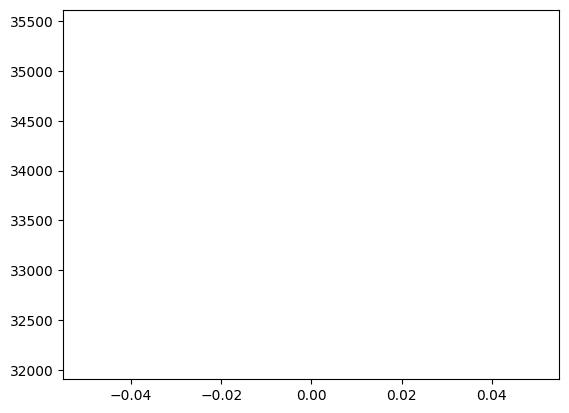

In [70]:
plt.plot(loss_list)